In [1]:
from math import pi
from cmath import exp
from sklearn import mixture
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import itertools
from sympy.combinatorics.permutations import Permutation

L = 1

In [2]:
def exponente(K, X):
    return exp(1j*np.sum(np.dot(K, X)))

# Construye función de onda
def psi(X, K):
    suma = 0
    # Orden del simplex de las posiciones
    Pfun = np.argsort(X)
    for P in itertools.permutations(Pfun):
        p = Permutation(Pfun[list(P)])
        coef = p.parity()
        if coef:
            coef = 1
        else:
            coef = -1       
        K_prime = K[list(P)]
        suma += coef * exponente(K_prime, X)
    return suma

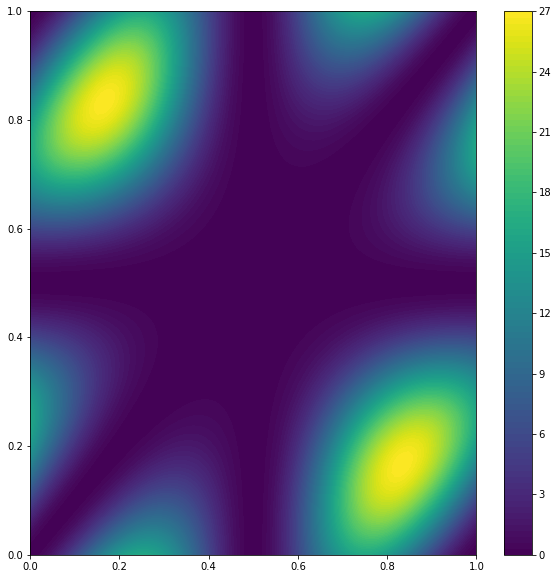

In [137]:
# Estado base
def get_K( N ):
    ks = [ 2*pi/L*( j + (N-1)/2.0) for j in range(1,N+1)]
    return ks
        
K = np.array( get_K(3) )

x1 = np.linspace(0, L, 100)
x2 = np.linspace(0, L, 100)

XX, YY = np.meshgrid(x1, x2)

Z = np.empty((100,100),dtype=np.complex)

# Dejamos la tercera partícula en la mitad de la caja
for i, x in enumerate(x1):
    for j, y in enumerate(x2):
        X = np.array([x, y, 0.5*L])
        Z[i, j] = psi(X, K)
        
plt.figure(figsize=(10,10))
plt.contourf(XX, YY, np.abs(Z)**2, levels=100)
plt.colorbar()
plt.show()

In [4]:
def gen_num(a, b):
    """
    Genera número aleatorio uniformemente distribuido entre a y b
    """
    return (b - a) * np.random.sample() + a


# 3 particulas:
def MCMC( N , z0):
    """
    Metropolis-Hastings
    """

    x1w = [gen_num(-L, 2*L)]
    x2w = [gen_num(-L, 2*L)]
    
    for i in range(N):
        x1p = gen_num(-L, 2*L)
        x2p = gen_num(-L, 2*L)
        
        Xp = np.array([x1p,x2p,z0])
        Xw = np.array([x1w[i],x2w[i],z0])
        alpha = np.abs(psi( Xp, K ))**2/np.abs( psi( Xw, K ))**2
        
        if alpha >= 1.0:
            x1w.append( x1p )
            x2w.append( x2p )
        else:
            beta = np.random.sample()
            if beta <= alpha:
                x1w.append( x1p )
                x2w.append( x2p )
            else:
                x1w.append( x1w[i] )
                x2w.append( x2w[i] )
    return x1w, x2w

In [5]:
X1W, X2W = MCMC(1000000, 0.5*L)

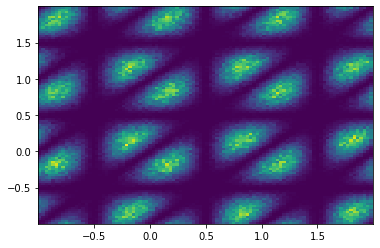

In [6]:
# Histograma 2D de puntos muestreados con la distribución de la función de onda del estado base.
plt.hist2d(X1W,X2W, bins=100)
plt.show()

In [7]:
X = np.c_[X1W,X2W]

# Modelo GMM-EM
gmm = mixture.GaussianMixture(n_components=20, covariance_type='full').fit(X)

In [8]:
# Muestreo de puntos del modelo gmm ajustado a los datos X
Xs = gmm.sample(n_samples=1000000)

# Nos restringimos a la caja fundamental de 0 a L
Xs_ = Xs[0][(Xs[0][:,0]>=0)&(Xs[0][:,0]<=L)&(Xs[0][:,1]>=0)&(Xs[0][:,1]<=L)]
X_ = X[(X[:,0]>=0)&(X[:,0]<=L)&(X[:,1]>=0)&(X[:,1]<=L)]

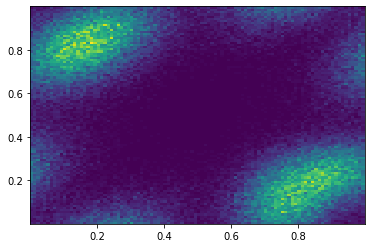

In [9]:
# Histograma de datos del GMM
Hs = plt.hist2d(*Xs_.T, bins=100)
plt.show()

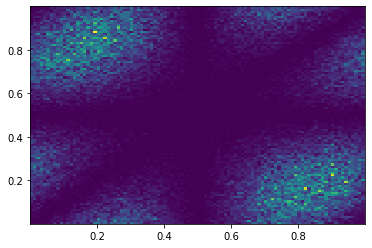

In [62]:
# Histograma de datos muestreados del estado base
Ht = plt.hist2d(*X_.T, bins=100)
plt.show()

In [98]:
# Histogramas normalizados

Hs_norm = Hs[0]/np.trapz(np.trapz(Hs[0],dx=xplot[1],axis=0),dx=xplot[1],axis=0)
Ht_norm = Ht[0]/np.trapz(np.trapz(Ht[0],dx=xplot[1],axis=0),dx=xplot[1],axis=0)

In [99]:
# Gráfica del error entre los dos histogramas
xplot = np.linspace(0, L, 100)
yplot = np.linspace(0, L, 100)

xx, yy = np.meshgrid(xplot, yplot)

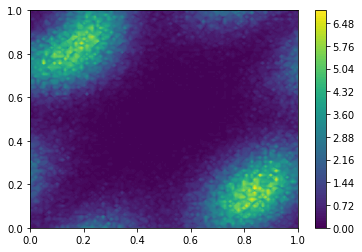

In [177]:
plt.contourf(xx, yy, Hs_norm, levels=100)
plt.colorbar()
plt.show()

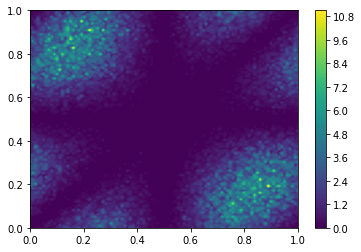

In [178]:
plt.contourf(xx, yy, Ht_norm, levels=100)
plt.colorbar()
plt.show()

In [251]:
Z1 = np.abs(Z)**2/np.trapz(np.trapz(np.abs(Z)**2,dx=0.01,axis=0),dx=0.01,axis=0)
Z2=Z1+10**-111
np.trapz(np.trapz(Z1,dx=0.01,axis=0),dx=0.01,axis=0)

1.0000000000000002

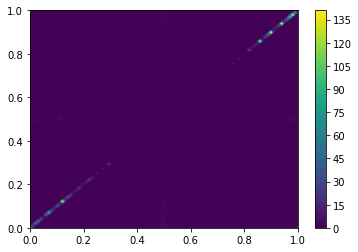

In [241]:
plt.contourf(xx, yy, sp.special.kl_div(Hs_norm,Z2), levels=100)
plt.colorbar()
plt.show()

In [242]:
KL = np.trapz(np.trapz(sp.special.kl_div(Hs_norm,Z2),dx=xplot[1],axis=0),dx=xplot[1],axis=0)
KL

0.28617540728842006

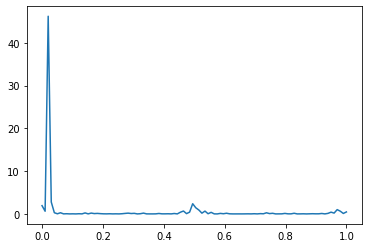

In [245]:
plt.plot(x1,sp.special.kl_div(Hs_norm,Z2)[2])

In [247]:
x_values = np.linspace(0,100,10000)
y1_values = sp.stats.norm(10, 3).pdf(x_values)
y2_values = sp.stats.norm(10.0001, 3).pdf(x_values)

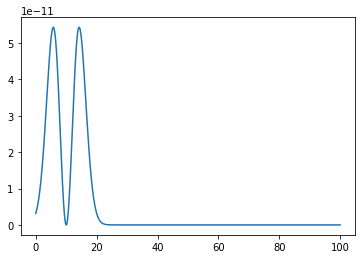

In [248]:
plt.plot(x_values,sp.special.kl_div(y1_values,y2_values))
plt.show()

In [249]:
KLe = np.trapz(sp.special.kl_div(y1_values,y2_values),dx=0.01)
KLe

5.524059398245895e-10